<a href="https://colab.research.google.com/github/SophyyCC/GEOG761-Project/blob/main/Amanda_CNN_(v3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================
# PART 1: Data Loading (Keep your existing code)
# ============================================
# Install required package
!pip install gdown

import zipfile, os
import random
from glob import glob
import shutil
from PIL import Image
import urllib.request

dropbox_link = "https://www.dropbox.com/scl/fo/mauujpylbyf5r9md6mw2v/AOHvMi9ATu7smWgBeJgeN78?rlkey=oiyod9ack4n1og6z68lrk8nq4&e=2&st=iv1hz2rm&dl=1"

print("Downloading from Dropbox...")
urllib.request.urlretrieve(dropbox_link, "patches.zip")
print("Download complete!")

print("Extracting files...")
with zipfile.ZipFile("patches.zip", 'r') as zip_ref:
    zip_ref.extractall("patches")
print("Extraction complete!")

extract_dir = "/content/patches"



Download complete!
Extracting files...
Extraction complete!


#After running the code to import the pacthes, please only run the code that does NOT use augumentation (at the bottom) otherwise the session will crash)


In [2]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, callbacks
import numpy as np
import gc

# Clear previous sessions
tf.keras.backend.clear_session()
gc.collect()

0

In [3]:
# ============================================
# PART 1: Load Dataset
# ============================================
data_dir = "/content/patches"  # Your full 6000 image dataset
img_size = (256, 256)
batch_size = 16  # Optimized for T4 GPU
seed = 42

print("Loading dataset...")

# Create splits
train_ds = image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_test_ds = image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

# Split validation and test
val_batches = tf.data.experimental.cardinality(val_test_ds)
test_ds = val_test_ds.take(val_batches // 2)
val_ds = val_test_ds.skip(val_batches // 2)

print(f"✓ Train batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"✓ Val batches:   {tf.data.experimental.cardinality(val_ds)}")
print(f"✓ Test batches:  {tf.data.experimental.cardinality(test_ds)}")


Loading dataset...
Found 6000 files belonging to 3 classes.
Using 4800 files for training.
Found 6000 files belonging to 3 classes.
Using 1200 files for validation.
✓ Train batches: 300
✓ Val batches:   38
✓ Test batches:  37


In [4]:
# ============================================
# Aggressive Data Augmentation
# ============================================
AUTOTUNE = tf.data.AUTOTUNE

normalization_layer = layers.Rescaling(1./255)

# Stronger augmentation for aerial imagery
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5),  # 180° rotation
    layers.RandomZoom(0.15, 0.15),  # ±15% zoom
    layers.RandomTranslation(0.1, 0.1),  # 10% shifts
    layers.RandomContrast(0.2),  # Brightness variation
], name='augmentation')

def preprocess_train(ds):
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x, y: (normalization_layer(x), y),
                num_parallel_calls=AUTOTUNE)
    return ds.shuffle(1000).prefetch(AUTOTUNE)

def preprocess_val_test(ds):
    ds = ds.map(lambda x, y: (normalization_layer(x), y),
                num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds = preprocess_train(train_ds)
val_ds = preprocess_val_test(val_ds)
test_ds = preprocess_val_test(test_ds)

print("✓ Data augmentation applied")

✓ Data augmentation applied


In [5]:
# ============================================
# Improved Model (Higher Dropout)
# ============================================

model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3,3), activation='relu', input_shape=img_size + (3,)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    # Block 2
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.35),

    # Block 3
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    # Classification
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
], name='liquefaction_cnn')

# Compile WITHOUT label smoothing (simpler, still effective)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',  # Simple string version
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "liquefaction_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,043 (433.76 KB)

 Trainable params: 110,595 (432.01 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# ============================================
# PART 5: Training with Improved Callbacks
# ============================================

callbacks_list = [
    # Stop if no improvement for 7 epochs
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when plateauing
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),

    # Save best model
    callbacks.ModelCheckpoint(
        'best_liquefaction_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("\n" + "="*60)
print("🚀 STARTING IMPROVED TRAINING")
print("="*60)
print("Dataset: 6000 images (perfectly balanced)")
print("  • high_risk: 2000 images")
print("  • medium_risk: 2000 images")
print("  • low_risk: 2000 images")
print("\nKey improvements vs previous run (80.9% val acc):")
print("  ✓ Stronger augmentation (zoom, translation, contrast)")
print("  ✓ Higher dropout rates (20% → 50%)")
print("  ✓ GlobalAveragePooling (more efficient)")
print("  ✓ Moderate learning rate (0.0005)")
print("\nTarget: Achieve >85% validation accuracy")
print("="*60 + "\n")

# Train WITHOUT class weights (balanced dataset)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks_list,
    verbose=1
)

print("\n✅ Training complete!")


🚀 STARTING IMPROVED TRAINING
Dataset: 6000 images (perfectly balanced)
  • high_risk: 2000 images
  • medium_risk: 2000 images
  • low_risk: 2000 images

Key improvements vs previous run (80.9% val acc):
  ✓ Stronger augmentation (zoom, translation, contrast)
  ✓ Higher dropout rates (20% → 50%)
  ✓ GlobalAveragePooling (more efficient)
  ✓ Moderate learning rate (0.0005)

Target: Achieve >85% validation accuracy

Epoch 1/50
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5505 - loss: 0.9730
Epoch 1: val_accuracy improved from -inf to 0.31908, saving model to best_liquefaction_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 115s 51ms/step - accuracy: 0.5510 - loss: 0.9722 - val_accuracy: 0.3191 - val_loss: 2.4139 - learning_rate: 5.0000e-04
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6989 - loss: 0.7142
Epoch 2: val_accuracy improved from 0.31908 to 0.37829, saving model to best_liquefaction_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 103s 49ms/step - accuracy: 0.

Claude raM freidnldy code

In [ ]:
# ============================================
# RAM-OPTIMIZED TRAINING
# ============================================

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, callbacks
import numpy as np
import gc

# CRITICAL: Clear everything first
tf.keras.backend.clear_session()
gc.collect()

print("🔧 RAM-Optimized Configuration")

# REDUCED batch size
data_dir = "/content/patches"
img_size = (256, 256)
batch_size = 8  # Reduced from 16
seed = 42

# Create splits
train_ds = image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_test_ds = image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_batches = tf.data.experimental.cardinality(val_test_ds)
test_ds = val_test_ds.take(val_batches // 2)
val_ds = val_test_ds.skip(val_batches // 2)

print(f"✓ Batch size: {batch_size} (reduced for RAM)")

# ============================================
# LIGHTWEIGHT Augmentation
# ============================================
AUTOTUNE = tf.data.AUTOTUNE

normalization_layer = layers.Rescaling(1./255)

# Simplified augmentation (less memory intensive)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.1, 0.1),  # Reduced from 0.15
], name='augmentation')

def preprocess_train(ds):
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x, y: (normalization_layer(x), y),
                num_parallel_calls=AUTOTUNE)
    return ds.shuffle(300).prefetch(AUTOTUNE)  # Smaller shuffle buffer

def preprocess_val_test(ds):
    ds = ds.map(lambda x, y: (normalization_layer(x), y),
                num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds = preprocess_train(train_ds)
val_ds = preprocess_val_test(val_ds)
test_ds = preprocess_val_test(test_ds)

print("✓ Lightweight augmentation applied")

# ============================================
# Model
# ============================================

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=img_size + (3,)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.35),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Model compiled")

# ============================================
# Training
# ============================================

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        'best_liquefaction_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("\n" + "="*60)
print("🚀 TRAINING (RAM-Optimized)")
print("="*60)
print(f"Batch size: {batch_size}")
print(f"Expected batches per epoch: ~{4800//batch_size}")
print("="*60 + "\n")

# Force garbage collection before training
gc.collect()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks_list,
    verbose=1
)

# ============================================
# Evaluation
# ============================================

print("\n📊 RESULTS")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")

best_val_acc = max(history.history['val_accuracy'])
print(f"Best Val Accuracy: {best_val_acc*100:.2f}%")

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.axhline(y=0.809, color='r', linestyle='--', label='Previous Best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

🔧 RAM-Optimized Configuration
Found 6000 files belonging to 3 classes.
Using 4800 files for training.
Found 6000 files belonging to 3 classes.
Using 1200 files for validation.
✓ Batch size: 8 (reduced for RAM)
✓ Lightweight augmentation applied


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✓ Model compiled

🚀 TRAINING (RAM-Optimized)
Batch size: 8
Expected batches per epoch: ~600

Epoch 1/50
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5498 - loss: 0.9776
Epoch 1: val_accuracy improved from -inf to 0.54167, saving model to best_liquefaction_model.keras
600/600 ━━━━━━━━━━━━━━━━━━━━ 86s 73ms/step - accuracy: 0.5500 - loss: 0.9773 - val_accuracy: 0.5417 - val_loss: 1.0688 - learning_rate: 5.0000e-04
Epoch 2/50
598/600 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6707 - loss: 0.7605
Epoch 2: val_accuracy did not improve from 0.54167
600/600 ━━━━━━━━━━━━━━━━━━━━ 77s 74ms/step - accuracy: 0.6707 - loss: 0.7605 - val_accuracy: 0.4517 - val_loss: 1.5094 - learning_rate: 5.0000e-04
Epoch 3/50
598/600 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7047 - loss: 0.7110
Epoch 3: val_accuracy improved from 0.54167 to 0.71167, saving model to best_liquefaction_model.keras
600/600 ━━━━━━━━━━━━━━━━━━━━ 76s 73ms/step - accuracy: 0.7047 - loss: 0.7110 - val_accuracy: 0.7117 

#No augumentation code

🚀 Training WITHOUT augmentation
Using alternative regularization strategies

Found 6000 files belonging to 3 classes.
Using 4800 files for training.
Found 6000 files belonging to 3 classes.
Using 1200 files for validation.
✓ Train batches: 150
✓ Val batches:   19
✓ Test batches:  19
✓ Simple normalization applied (no augmentation)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MODEL ARCHITECTURE
Strategy: Deeper network + L2 regularization + high dropout
  • 4 convolutional blocks (added 256-filter block)
  • 2 dense layers (256 → 128 → 3)
  • L2 regularization on all conv/dense layers
  • Dropout: 25% → 50% (increasing)
  • GlobalAveragePooling (parameter efficient)



Model: "deep_liquefaction_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 489,411 (1.87 MB)

 Trainable params: 488,451 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)

🚀 TRAINING DEEP MODEL
Previous best: 80.9% validation accuracy
Target: >85% with deeper architecture + regularization

Epoch 1/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4554 - loss: 1.9502
Epoch 1: val_accuracy improved from -inf to 0.29561, saving model to best_liquefaction_model_deep.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 129ms/step - accuracy: 0.4558 - loss: 1.9488 - val_accuracy: 0.2956 - val_loss: 2.3438 - learning_rate: 3.0000e-04
Epoch 2/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6700 - loss: 1.4709
Epoch 2: val_accuracy improved from 0.29561 to 0.32264, saving model to best_liquefaction_model_deep.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.6701 - loss: 1.4705 - val_accuracy: 0.3226 - val_loss: 2.7415 - learning_rate: 3.0000e-04
Epoch 3/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7368 - loss: 1.2841
Epoch 3: val_accuracy did not improve from 0.32264
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.7368 -

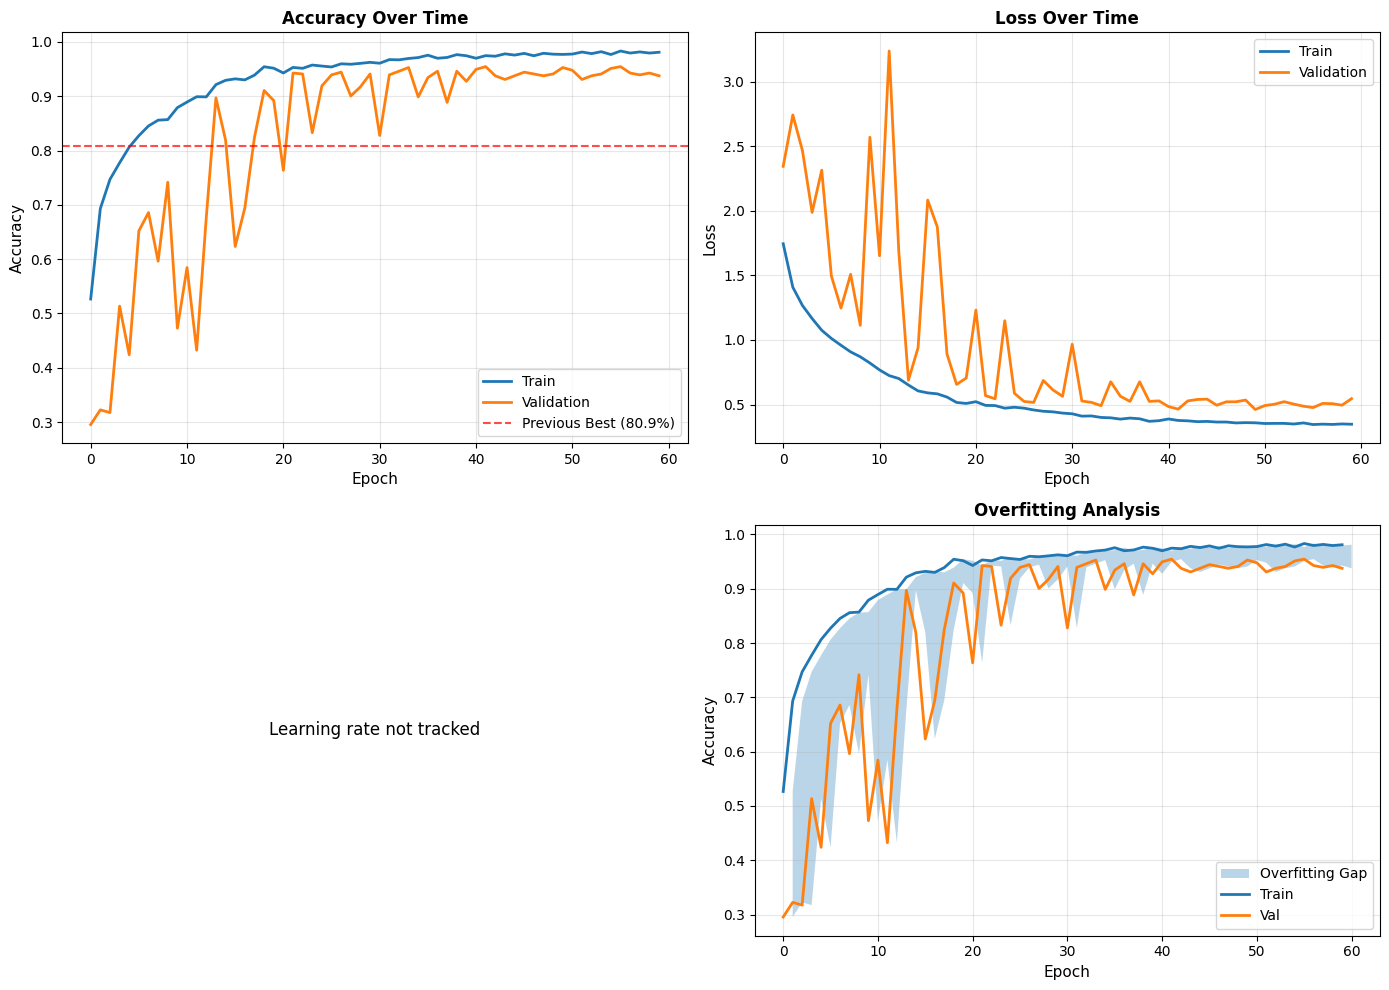


✅ Analysis complete!

💡 NEXT STEPS
🎉 Great performance! Consider:
  • Test on real unseen data
  • Analyze confusion matrix for error patterns
  • Deploy model for inference


In [2]:
# ============================================
# LIQUEFACTION CNN - NO AUGMENTATION VERSION
# Alternative strategies to beat 80.9% val accuracy
# ============================================

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, callbacks, regularizers
import numpy as np
import gc

# Clear memory
tf.keras.backend.clear_session()
gc.collect()

print("🚀 Training WITHOUT augmentation")
print("Using alternative regularization strategies\n")

# ============================================
# PART 1: Load Dataset (Simple & Fast)
# ============================================

data_dir = "/content/patches"
img_size = (256, 256)
batch_size = 32  # Can use larger batch without augmentation
seed = 42

train_ds = image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_test_ds = image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_batches = tf.data.experimental.cardinality(val_test_ds)
test_ds = val_test_ds.take(val_batches // 2)
val_ds = val_test_ds.skip(val_batches // 2)

print(f"✓ Train batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"✓ Val batches:   {tf.data.experimental.cardinality(val_ds)}")
print(f"✓ Test batches:  {tf.data.experimental.cardinality(test_ds)}")

# ============================================
# PART 2: Simple Preprocessing (No Augmentation)
# ============================================

AUTOTUNE = tf.data.AUTOTUNE

# Just normalize
def normalize(ds):
    return ds.map(lambda x, y: (x/255.0, y),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

train_ds = normalize(train_ds)
val_ds = normalize(val_ds)
test_ds = normalize(test_ds)

print("✓ Simple normalization applied (no augmentation)\n")

# ============================================
# PART 3: DEEPER MODEL with L2 Regularization
# Strategy: More capacity + strong regularization
# ============================================

model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3,3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001),
                  input_shape=img_size + (3,)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(64, (3,3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    # Block 3
    layers.Conv2D(128, (3,3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.35),

    # Block 4 - ADDITIONAL DEPTH
    layers.Conv2D(256, (3,3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    # Classification
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
], name='deep_liquefaction_cnn')

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),  # Lower LR for deeper model
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("="*60)
print("MODEL ARCHITECTURE")
print("="*60)
print("Strategy: Deeper network + L2 regularization + high dropout")
print("  • 4 convolutional blocks (added 256-filter block)")
print("  • 2 dense layers (256 → 128 → 3)")
print("  • L2 regularization on all conv/dense layers")
print("  • Dropout: 25% → 50% (increasing)")
print("  • GlobalAveragePooling (parameter efficient)")
print("="*60 + "\n")

model.summary()

# ============================================
# PART 4: Advanced Callbacks
# ============================================

callbacks_list = [
    # Early stopping with longer patience
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,  # Increased patience for deeper model
        restore_best_weights=True,
        verbose=1
    ),

    # Aggressive learning rate reduction
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-7,
        verbose=1
    ),

    # Save best model
    callbacks.ModelCheckpoint(
        'best_liquefaction_model_deep.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# ============================================
# PART 5: Training
# ============================================

print("="*60)
print("🚀 TRAINING DEEP MODEL")
print("="*60)
print("Previous best: 80.9% validation accuracy")
print("Target: >85% with deeper architecture + regularization")
print("="*60 + "\n")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,  # More epochs for deeper model
    callbacks=callbacks_list,
    verbose=1
)

# ============================================
# PART 6: Comprehensive Evaluation
# ============================================

print("\n" + "="*60)
print("📊 FINAL RESULTS")
print("="*60)

# Test set evaluation
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\n🎯 Test Set Performance:")
print(f"   Accuracy: {test_acc*100:.2f}%")
print(f"   Loss: {test_loss:.4f}")

# Best validation performance
best_val_acc = max(history.history['val_accuracy'])
best_epoch = np.argmax(history.history['val_accuracy']) + 1
train_acc_at_best = history.history['accuracy'][best_epoch-1]
val_loss_at_best = history.history['val_loss'][best_epoch-1]

print(f"\n📈 Best Validation Performance:")
print(f"   Validation Accuracy: {best_val_acc*100:.2f}%")
print(f"   Validation Loss: {val_loss_at_best:.4f}")
print(f"   Achieved at epoch: {best_epoch}")

print(f"\n🔍 Overfitting Analysis:")
train_val_gap = (train_acc_at_best - best_val_acc) * 100
print(f"   Training accuracy: {train_acc_at_best*100:.2f}%")
print(f"   Validation accuracy: {best_val_acc*100:.2f}%")
print(f"   Train-Val gap: {train_val_gap:.2f}%")

if train_val_gap < 5:
    print(f"   ✅ Good generalization (gap < 5%)")
elif train_val_gap < 8:
    print(f"   ⚠️ Slight overfitting (gap 5-8%)")
else:
    print(f"   ❌ Significant overfitting (gap > 8%)")

print(f"\n📊 Improvement vs Previous:")
improvement = (best_val_acc - 0.809) * 100
if improvement > 0:
    print(f"   ✅ Improved by {improvement:.2f} percentage points!")
else:
    print(f"   ⚠️ Decreased by {abs(improvement):.2f} percentage points")

# Validation loss stability
val_losses = history.history['val_loss']
max_val_loss = max(val_losses)
min_val_loss = min(val_losses)
loss_volatility = max_val_loss / min_val_loss

print(f"\n📉 Training Stability:")
print(f"   Max val loss: {max_val_loss:.4f}")
print(f"   Min val loss: {min_val_loss:.4f}")
print(f"   Volatility ratio: {loss_volatility:.2f}x")
if loss_volatility < 3:
    print(f"   ✅ Stable training")
else:
    print(f"   ⚠️ Unstable validation loss")

print("="*60)

# ============================================
# PART 7: Visualization
# ============================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy over time
axes[0, 0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0, 0].axhline(y=0.809, color='r', linestyle='--', label='Previous Best (80.9%)', alpha=0.7)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Accuracy', fontsize=11)
axes[0, 0].set_title('Accuracy Over Time', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss over time
axes[0, 1].plot(history.history['loss'], label='Train', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Loss', fontsize=11)
axes[0, 1].set_title('Loss Over Time', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning rate over time
if 'lr' in history.history:
    axes[1, 0].plot(history.history['lr'], linewidth=2, color='green')
    axes[1, 0].set_xlabel('Epoch', fontsize=11)
    axes[1, 0].set_ylabel('Learning Rate', fontsize=11)
    axes[1, 0].set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'Learning rate not tracked',
                    ha='center', va='center', fontsize=12)
    axes[1, 0].axis('off')

# Train vs Val accuracy comparison
epochs_range = range(1, len(history.history['accuracy']) + 1)
axes[1, 1].fill_between(epochs_range,
                         history.history['accuracy'],
                         history.history['val_accuracy'],
                         alpha=0.3, label='Overfitting Gap')
axes[1, 1].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[1, 1].plot(history.history['val_accuracy'], label='Val', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('Accuracy', fontsize=11)
axes[1, 1].set_title('Overfitting Analysis', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Analysis complete!")

# ============================================
# PART 8: Next Steps Recommendations
# ============================================

print("\n" + "="*60)
print("💡 NEXT STEPS")
print("="*60)

if best_val_acc > 0.85:
    print("🎉 Great performance! Consider:")
    print("  • Test on real unseen data")
    print("  • Analyze confusion matrix for error patterns")
    print("  • Deploy model for inference")
elif best_val_acc > 0.809:
    print("✅ Improvement achieved! To go further:")
    print("  • Try transfer learning (EfficientNet, ResNet)")
    print("  • Ensemble multiple models")
    print("  • Collect more training data")
else:
    print("⚠️ No improvement. Consider:")
    print("  • Transfer learning (pre-trained on ImageNet)")
    print("  • Different architecture (ResNet, EfficientNet)")
    print("  • Check data quality (mislabeled images?)")
    print("  • Feature engineering (additional input channels)")

print("="*60)

Precision (weighted): 0.958
Class 0 Average Precision (AP): 0.974
Class 1 Average Precision (AP): 0.994
Class 2 Average Precision (AP): 0.991

Mean Average Precision (mAP): 0.986

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       189
           1       0.96      0.98      0.97       198
           2       0.99      0.91      0.95       205

    accuracy                           0.96       592
   macro avg       0.96      0.96      0.96       592
weighted avg       0.96      0.96      0.96       592



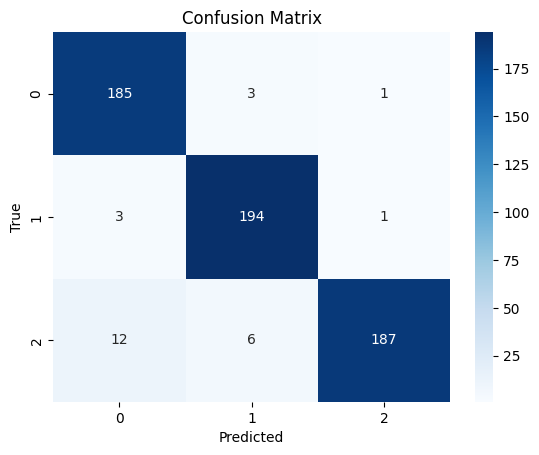

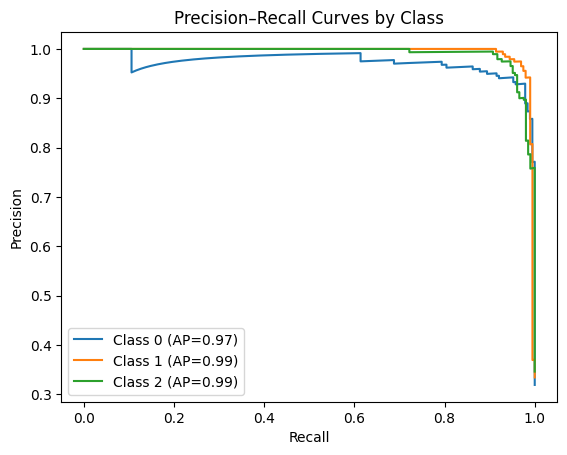

In [3]:
# Step 6. Evaluate model performance: Precision and Average Precision
import numpy as np
from sklearn.metrics import precision_score, average_precision_score, classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Collect predictions and true labels from the validation dataset
y_true = []
y_pred_probs = []
y_pred_classes = []

for images, labels in val_ds:
    probs = model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(probs)
    y_pred_classes.extend(preds)

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_classes = np.array(y_pred_classes)

# 2️⃣ Precision at fixed threshold (predicted class)
precision = precision_score(y_true, y_pred_classes, average='weighted')
print(f"Precision (weighted): {precision:.3f}")

# 3️⃣ Average Precision (AP) per class + mean AP (mAP)
from sklearn.preprocessing import label_binarize
n_classes = y_pred_probs.shape[1]
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

ap_per_class = []
for i in range(n_classes):
    ap = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])
    ap_per_class.append(ap)
    print(f"Class {i} Average Precision (AP): {ap:.3f}")

mAP = np.mean(ap_per_class)
print(f"\nMean Average Precision (mAP): {mAP:.3f}")

# 4️⃣ Optional: classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 5️⃣ Optional: Precision–Recall curves for each class
for i in range(n_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall_vals, precision_vals, label=f'Class {i} (AP={ap_per_class[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curves by Class')
plt.legend()
plt.show()
